In [1]:
from my_commonfunctions import *
from matplotlib import cm
from skimage.transform import probabilistic_hough_line
import skimage.morphology as skm

# Used functions

In [2]:
def get_rotation_angle(img):
    image = img
    edges = canny(image, 2, 1, 25)
    lines = probabilistic_hough_line(edges, threshold=50, line_length=50,
                                     line_gap=30)

    
    _range = 50 if len(lines) >= 50 else len(lines)
    
    angles = []
    for i in range(_range):
        p1,p2 = lines[i]
        angles.append(math.degrees(math.atan2(p2[1]-p1[1],p2[0]-p1[0])))
        if angles[i] < 0 :
            angles[i] = -1 * angles[i]
        if (angles[i] > 90):
            angles[i] = -1 * (180-angles[i])
    
    angle = np.median(np.array(angles))
    return angle

In [3]:
def rotate_bound(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])


    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))


    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    return cv2.warpAffine(image, M, (nW, nH),borderValue=(255,255,255))

In [4]:
def get_distance_between_staves_and_staff_thickness(img_binary_bg_white):
    img_height = img_binary_bg_white.shape[0]
    
    flattened = img_binary_bg_white.T.flatten()
    flattened_indices = np.arange(0, flattened.shape[0], 1, np.uint32)
    flattened[flattened_indices % img_height == 0] = False # Separate each column with a black pixel
    
    image, contours_distance, hierarchy = cv2.findContours((flattened*255).astype(np.uint8), 
                                                            cv2.RETR_TREE, 
                                                            cv2.CHAIN_APPROX_SIMPLE)

    image, contours_thickness, hierarchy = cv2.findContours(((~flattened)*255).astype(np.uint8), 
                                                            cv2.RETR_TREE, 
                                                            cv2.CHAIN_APPROX_SIMPLE)

    return most_frequent_white_length(img_height, contours_distance), most_frequent_white_length(img_height, contours_thickness)

In [5]:
def most_frequent_white_length(img_height, contours):
    # We refer to length as the vertical distance between 2 black pixels
    length_freq = np.zeros((img_height), dtype=np.uint32) # No contour can be taller than img_height because we separated each column with a black pixel
    all_possible_lengths = np.arange(0, img_height, 1, dtype=np.uint32)
    for i in contours:
        contour_y = i.T[1]
        length = contour_y[0][1] - contour_y[0][0] if len(contour_y[0]) == 2 else 1
        length_freq[length] += 1
    
    # plt.bar(all_possible_lengths, length_freq, width=3)
        
    return all_possible_lengths[length_freq == length_freq.max()][0]

# Read Image

In [24]:
test_gray = my_imread_gray('19.jpg')

[[171 171 170 ... 159 157 158]
 [170 172 173 ... 157 156 158]
 [171 174 175 ... 159 158 157]
 ...
 [140 143 143 ... 123 127 131]
 [142 144 144 ... 125 129 129]
 [140 142 142 ... 127 129 123]]


# Fix Rotation

In [25]:
angle = get_rotation_angle(test_gray)
angle

-47.1713377065236

In [26]:
test_gray_rotated = rotate_bound(test_gray, angle)

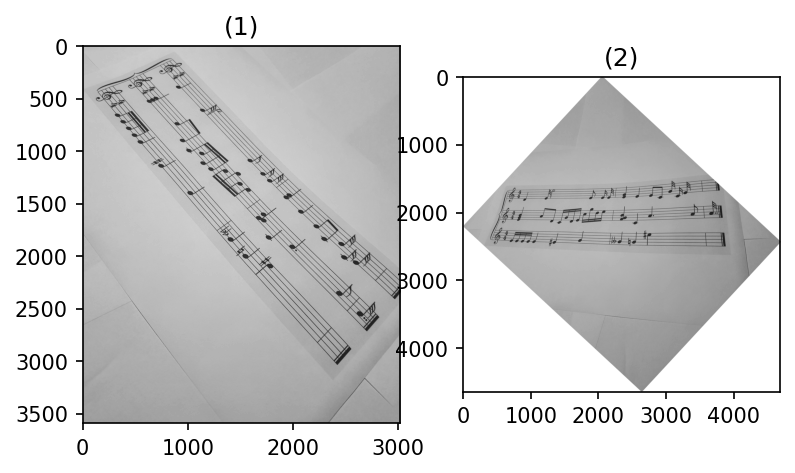

In [27]:
my_show_images([test_gray, test_gray_rotated], dpi=150, row_max=2)

# Canny & Adaptive

In [28]:
thresh = cv2.adaptiveThreshold(test_gray_rotated, 256, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 11)
thresh = cv2.medianBlur(thresh, 3)
edges = cv2.Canny(thresh, 100, 200)

#my_show_images([thresh, edges], dpi=150, row_max=2)

In [29]:
#io.imsave('test_rotated_thresh.png', thresh)

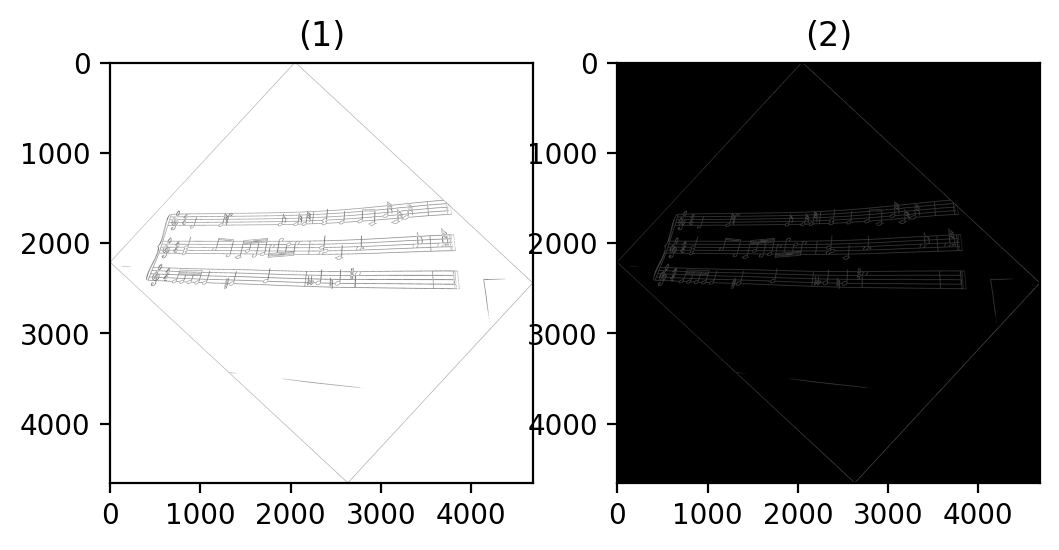

In [30]:
my_show_images([thresh, edges], dpi=200, row_max=2)

# Distance between staves -> Dilation -> Erosion -> Dilation

In [31]:
distance_between_staves, staff_thickness = get_distance_between_staves_and_staff_thickness(thresh)
kernel_size = distance_between_staves * 3
print(distance_between_staves, staff_thickness)
print(kernel_size)

29 2
87


In [32]:
k = np.ones((kernel_size, kernel_size))
k2 = np.ones((int(kernel_size*1.5), int(kernel_size*1.5)))
k3 = np.ones((kernel_size*6, kernel_size))
dilated = cv2.dilate(edges, k)
dilated_eroded = cv2.erode(dilated, k2)
dilated_eroded_dilated = cv2.dilate(dilated_eroded, k3)

# Contours

In [33]:
image, contours, hierarchy = cv2.findContours(dilated_eroded_dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
dilated_eroded_dilated_contours = cv2.drawContours(cv2.cvtColor((dilated_eroded_dilated*255).astype(np.uint8), cv2.COLOR_GRAY2RGB), contours, -1, (0,255,0), 3)
len(contours)

8

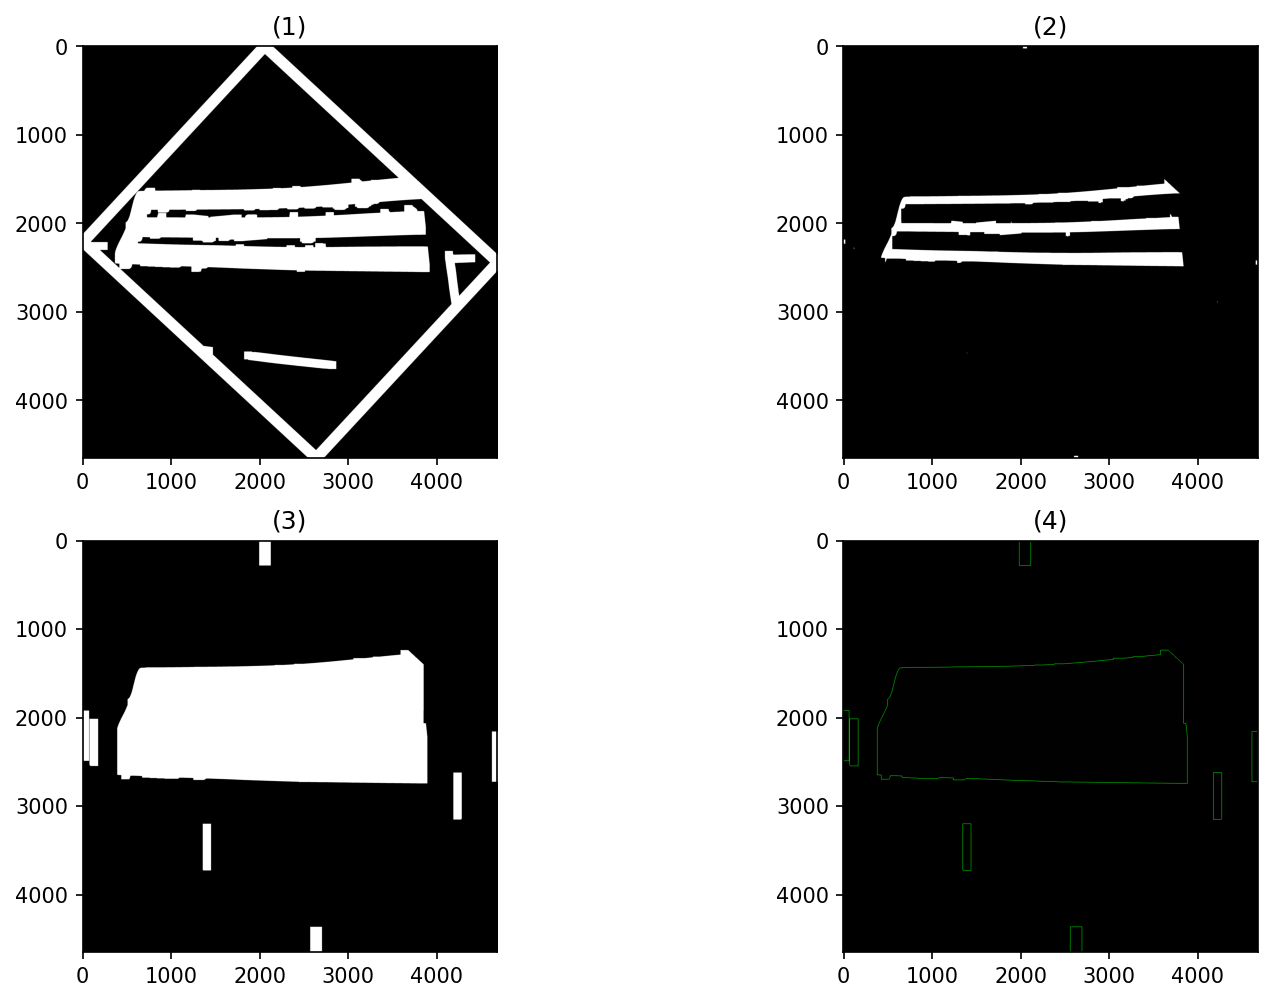

In [34]:
my_show_images([dilated, dilated_eroded, dilated_eroded_dilated, dilated_eroded_dilated_contours], dpi=150, row_max=2)

# Get the contour with the maximum area

In [35]:
i = 0
i_max = 0
area_max = 0
for c in contours:
    area = cv2.contourArea(c)
    if area > area_max:
        area_max = area
        i_max = i
    i += 1

i_max

6

In [36]:
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric

# The bounding box of the maximum area contour

x, y, w, h = cv2.boundingRect(contours[i_max])
x, y, w, h

(386, 1243, 3500, 1506)

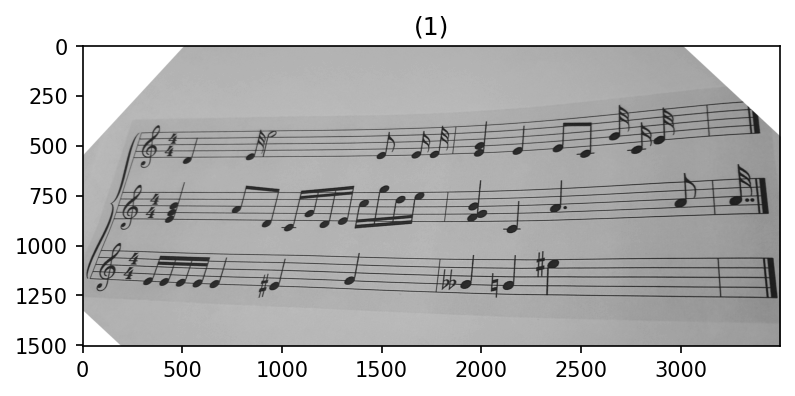

In [37]:
test_rotated_croped = test_gray_rotated[y:y+h, x:x+w]
my_show_images([test_rotated_croped], dpi=150, row_max=1)

In [1]:
edges = canny(test_rotated_croped, 2, 1, 25)
width = test_rotated_croped.shape[1]
lines = probabilistic_hough_line(edges, threshold=10, line_length=5, line_gap=3, theta=np.arange(np.pi/4, np.pi*3/4, np.pi/90))

lines_img = np.zeros(edges.shape)
for l in lines:
    x1 = l[0][0]
    y1 = l[0][1]
    x2 = l[1][0]
    y2 = l[1][1]
    #print(l)
    #print(x1, y1, x2, y2)
    cv2.line(lines_img, (x1,y1), (x2,y2), (255,255,255), 2)

my_show_images([edges, lines_img], dpi=200, row_max=2)

NameError: name 'canny' is not defined

In [93]:
print(width)

702


In [66]:
?probabilistic_hough_line

Signature:
probabilistic_hough_line(
    image,
    threshold=10,
    line_length=50,
    line_gap=10,
    theta=None,
    seed=None,
)
Docstring:
Return lines from a progressive probabilistic line Hough transform.

Parameters
----------
image : (M, N) ndarray
    Input image with nonzero values representing edges.
threshold : int, optional
    Threshold
line_length : int, optional
    Minimum accepted length of detected lines.
    Increase the parameter to extract longer lines.
line_gap : int, optional
    Maximum gap between pixels to still form a line.
    Increase the parameter to merge broken lines more aggressively.
theta : 1D ndarray, dtype=double, optional
    Angles at which to compute the transform, in radians.
    If None, use a range from -pi/2 to pi/2.
seed : int, optional
    Seed to initialize the random number generator.

Returns
-------
lines : list
  List of lines identified, lines in format ((x0, y0), (x1, y1)),
  indicating line start and end.

References
----------

In [21]:
# Staff lines removal

thresh = cv2.adaptiveThreshold(test_rotated_croped, 256, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 3)
thresh = cv2.medianBlur(thresh, 3)


se = np.ones((staff_thickness, staff_thickness*10))
img = thresh < 128
staff_lines = skm.dilation(skm.erosion(img, se), se)
staff_lines_median_blur = median(img * (~staff_lines), np.ones((3, 3)))
staff_lines_removed = skm.dilation(staff_lines_median_blur, np.ones((staff_thickness+3, staff_thickness+3)))

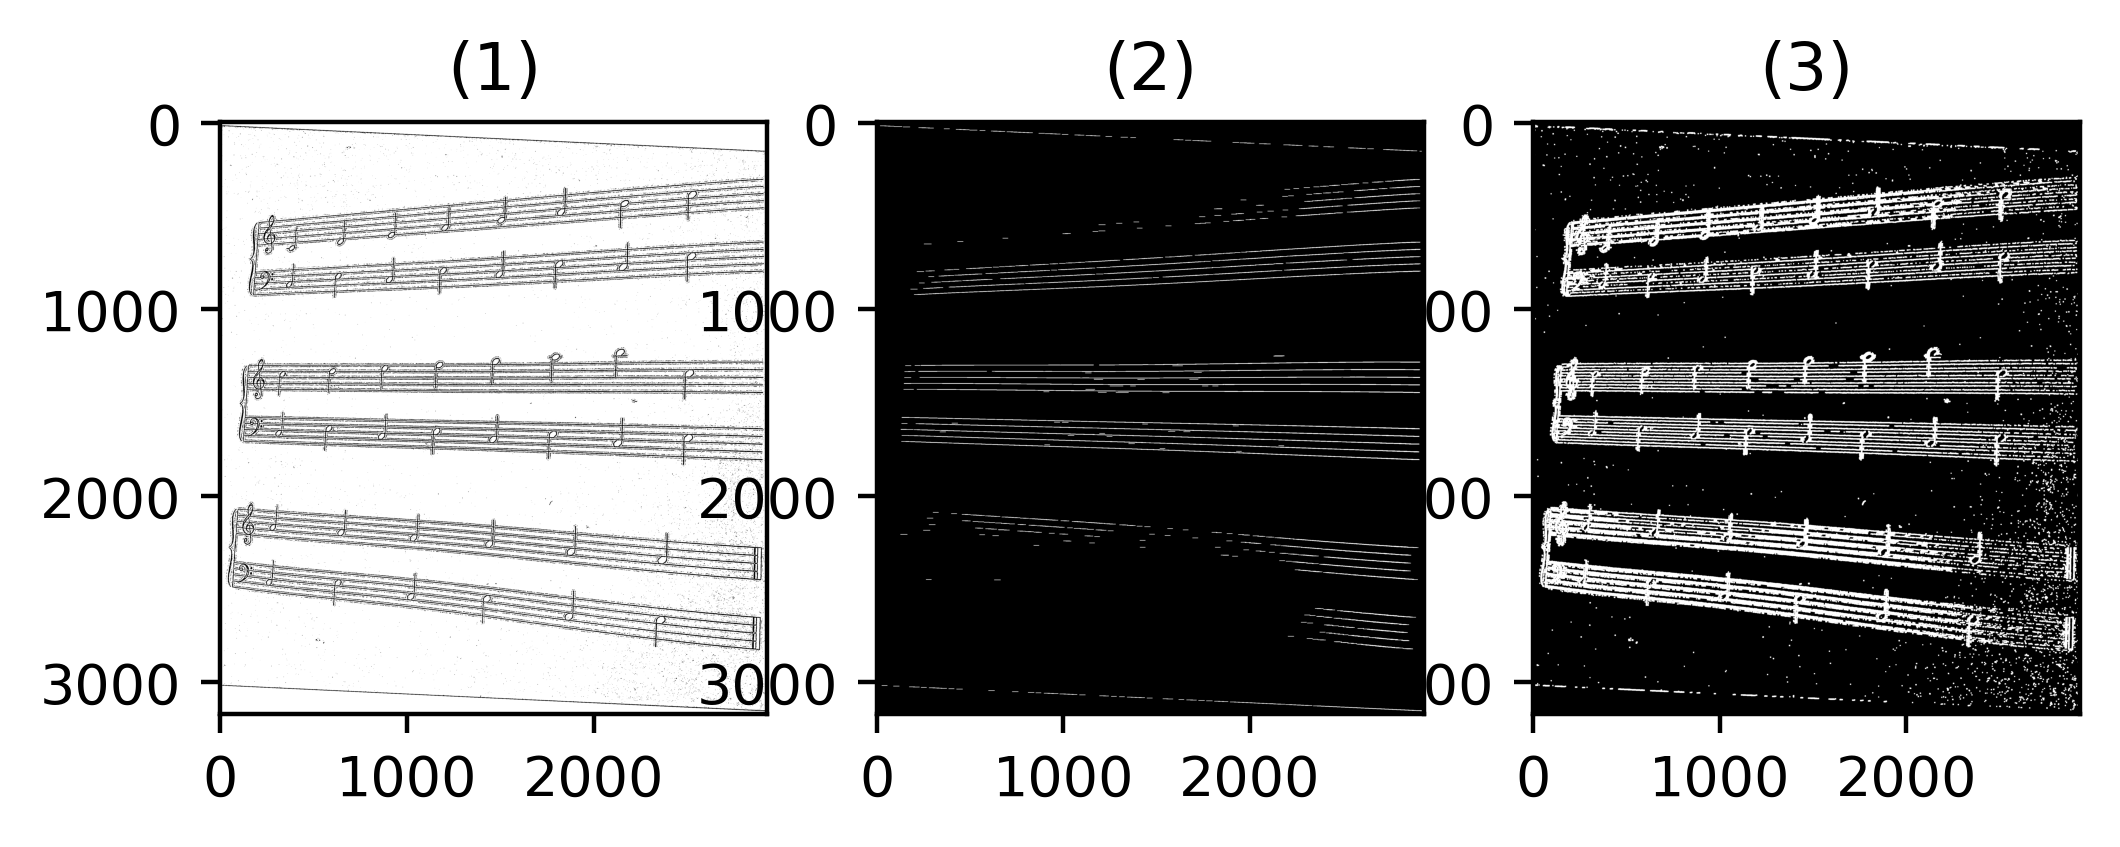

In [22]:
my_show_images([thresh, staff_lines, staff_lines_removed], row_max=3, dpi=400)